In [25]:
import devito as dv
from examples.seismic import Model
import numpy as np

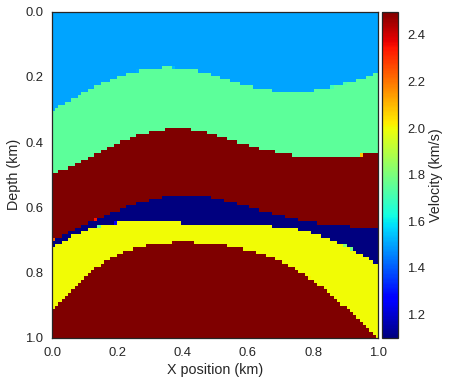

In [46]:
from examples.seismic import Model,plot_velocity, AcquisitionGeometry



gempy_vp = np.load("MODELO3D_FINAL.npy")[50, :,:].T
vpp = np.flip(gempy_vp,axis=0)
model = Model(vp=vpp.T, origin=(0.,0.), shape=(101,101), spacing=(10.,10.),
              nbl=40, space_order=2, bcs="damp")

plot_velocity(model)

In [47]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
ns=16

time_range = TimeAxis(start=t0, stop=tn, step=dt)

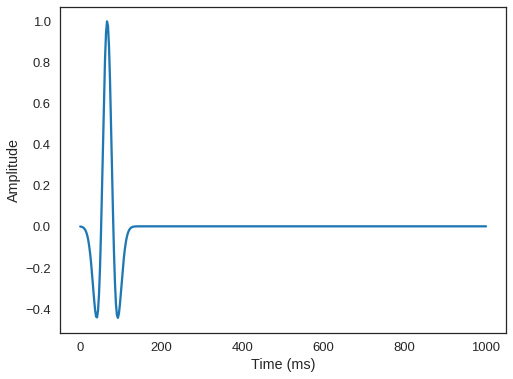

[[500. -20.]]


In [98]:
from examples.seismic import RickerSource

f0 = 0.015  
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)


src.coordinates.data[:] = 500
src.coordinates.data[0, -1] = -20  # Depth is 20m
src.show()
print(src.coordinates.data)


In [99]:
np.save("segundoshot",src.coordinates.data)

In [100]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, -1] = -20.  # Depth is 20m


In [101]:
u = dv.TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)

# We can now write the PDE
pde =model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [102]:
stencil = dv.Eq(u.forward, dv.solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [103]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [104]:
op = dv.Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [105]:
op(time=time_range.num-1, dt=model.critical_dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.022426000000000026, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.800000000000001e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0005720000000000052, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

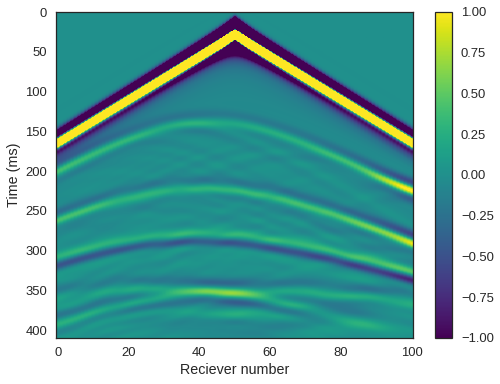

In [106]:
plt.imshow(rec.data, cmap='viridis', aspect='auto', vmax=1, vmin=-1)
plt.xlabel("Reciever number")
plt.ylabel("Time (ms)")
plt.colorbar()
plt.show()